In [1]:
# This script contains a neural-net algorithm to distinguish between 3 particle types (pions, kaons, and muons)
# The code is based on the sci-kit learn example by jackfrost373, also available in the present Git-repository


import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# get training data from the simulation-tree
tfile = uproot.open('/home/Shared/lhcbdata/davinci_MC_PID.root')
tree = tfile["PiTree/DecayTree"]
df = tree.pandas.df()
#print(df.head())


In [2]:
# make new PID label abs (so that particles and their antis are seen equivalently)
df['absid'] = df['pi_TRUEID'].abs()

print(df['absid'].value_counts()) # number of times each particle was detected

211     60058
321     11217
0        9015
2212     6650
13       4983
11       3616
3222       34
3112       10
3312        4
Name: absid, dtype: int64


In [3]:
# make cuts on dataset 
# pion = 211, kaon = 321, proton = 2212

crit_global = (df['pi_TRACK_time_err'] > 0.1) & (df['pi_P'] > 1200) #insert threshold values for track time error and momentum
crit_types  = (abs(df['pi_TRUEID']) == 211) | (abs(df['pi_TRUEID']) == 321) | (abs(df['pi_TRUEID']) == 2212) # only pion or kaon or proton
dfsel = df[crit_global & crit_types]
#print(dfsel)

In [5]:
# define 'attributes' to train on: (i.e. which variables?)

##########################
attributesTRACK = ['TrackP','TrackPt','TrackChi2PerDof','TrackNumDof','TrackLikelihood','TrackFitTChi2','TrackFitTNDoF','TrackFitMatchChi2',
                     'TrackGhostProbability','TrackCloneDist','TrackFitVeloChi2','TrackFitVeloNDoF',]
attributesRICH = ['RichUsedAero', 'RichUsedR1Gas', 'RichUsedR2Gas', 'RichAboveMuThres', 'RichAboveKaThres']
attributesDLLS = ['RichDLLe','RichDLLmu','RichDLLk','RichDLLp','RichDLLbt']
attributesCALO = ['EcalPIDe', 'EcalPIDmu', 'HcalPIDe', 'HcalPIDmu', 'PrsPIDe', 'InAccBrem', 'BremPIDe']
attributesOther = ['VeloCharge', 'pi_TRACK_time','pi_TRACK_time_err']
attributes = attributesTRACK + attributesRICH + attributesDLLS + attributesCALO + attributesOther
X = dfsel.loc[ :, attributes ]

#print(X.head())


In [ ]:
# define the numerical IDs (e.g ±211) as'labels' for the distinct particle types

y = dfsel['absid'].astype('category')
print(y.head())

In [8]:
# split sample into training and testing sets w/ an inbuilt scikit function
#for that: input data and the labels that classify it
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)




In [ ]:


# Now follows the machine learning bit...

In [9]:
# feature scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  


In [10]:
#train with My little pony... 
print("Training...") 
from sklearn.neural_network import MLPClassifier 
mlp = MLPClassifier(hidden_layer_sizes=(len(attributes), int(len(attributes)/2), 10), max_iter=200, activation='relu', solver='adam', verbose=0)
mlp.fit(X_train, y_train.values.ravel())


Training...


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(25, 12, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
# make label predictions on test data
predictions = mlp.predict(X_test)

# evaluation
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion matrix:")
print(confusion_matrix(y_test,predictions))
print("Classification report:")
print(classification_report(y_test,predictions))

Confusion matrix:
[[10239   124    53]
 [  434  1275   144]
 [  265   452   439]]
Classification report:
              precision    recall  f1-score   support

         211       0.94      0.98      0.96     10416
         321       0.69      0.69      0.69      1853
        2212       0.69      0.38      0.49      1156

   micro avg       0.89      0.89      0.89     13425
   macro avg       0.77      0.68      0.71     13425
weighted avg       0.88      0.89      0.88     13425



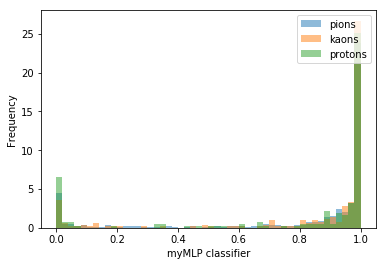

<Figure size 432x288 with 0 Axes>

In [15]:
# create a classification variable based on the prediction probability
probabilities = mlp.predict_proba(X_test) # gives list of [prob_pion, prob_kaon]
class_var = np.array( [ probabilities[i][0] for i in range(len(y_test)) ] ) # list of prob_pion
df_test = pd.DataFrame(data=X_test, columns=attributes)
df_test["myMLP"] = class_var
df_test["absid"] = y_test

# plot this variable for the 3 categories, aka particle types
crit_pion = df_test['absid'] == 211
crit_kaon = df_test['absid'] == 321
crit_proton = df_test['absid'] == 2212
df_test_pions = df_test[crit_pion]
df_test_kaons = df_test[crit_kaon]
df_test_protons = df_test[crit_proton]

df_test_pions["myMLP"].plot.hist(bins=50, range=(0,1), alpha=0.5, density=True, label="pions")
df_test_kaons["myMLP"].plot.hist(bins=50, range=(0,1), alpha=0.5, density=True, label="kaons")
df_test_protons["myMLP"].plot.hist(bins=50, range=(0,1), alpha=0.5, density=True, label="protons")
plt.legend(loc='upper right')
plt.xlabel("myMLP classifier")
plt.show()

f = plt.figure()
f.savefig("myMLP_performance.pdf", bbox_inches='tight')

In [ ]:
# cell reserved to "read in" experimental data later
...



In [ ]:
REPEAT PREDICITIONS FOR EXPERIMENTAL DATA...